In [1]:
import numpy as np
import ctypes, time, os, tqdm, pickle, sharedmem
from scipy.io import loadmat
from ipywidgets import interact, widgets

# Import visualization stuff
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface, write_surface

# Import popeye stuff
import popeye.og as og
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus, resample_stimulus
from popeye import css

# Import multiprocessing stuff
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor

# Load helper functions
from dataloader import set_paths, load_stimuli, copy_files
%load_ext autoreload
%autoreload 2

In [2]:
# Initialize parameters
params = {}
params['subjID'] = 'JC'
# Got these from Zhengang, and he got it from rsvp_params.txt
params['viewingDistance'] = 63 #83.5 # in cm
params['screenWidth'] = 35 #36.2 # in cm
params['scaleFactor'] = 1 #0.1
params['resampleFactor'] = 1 #1080/120
params['dtype'] = ctypes.c_int16

p = set_paths(params)

In [3]:
bar, stim_params = load_stimuli(p)
bar = bar[:, :, 0:201]
# Mirror y axis
bar = np.flip(bar, axis=0)
# Transpose x and y for bar
# bar = np.transpose(bar, (1, 0, 2))

# bar = resample_stimulus(bar, params['resampleFactor'])

copy_files(p, params)

# Extract number of TRs
method = 'ss5'

func_data = nib.load(p['pRF_' + method])
f_header = func_data.header
params['tr_length'] = f_header['pixdim'][4]
params['voxel_size'] = [f_header['pixdim'][i] for i in range(1, 4)]
params['nTRs'] = func_data.shape[-1]

# model to fit to
scan_data = func_data.get_fdata()
# scan_data = utils.percent_change(scan_data, ax=-1) # Convert to pct signal change

# Ground truth model-fit from mrVista
popeye_fit_path = os.path.join(p['pRF_data'], 'JC', 'mrVistaFit', 'RF_' + method + '-fFit.nii.gz')
mrVista_fit = nib.load(popeye_fit_path).get_fdata()

brainmask_data = nib.load(p['pRF_brainmask']).get_fdata() != 0
# Resample brainmask if first 2 dimensions are twice the third dimension
if brainmask_data.shape[0] == 2*brainmask_data.shape[2]:
    brainmask_data = brainmask_data[::2, ::2, :]

Subject folder already exists


In [4]:
# create stimulus object from popeye
stimulus = VisualStimulus(bar.astype('int16'),
                          params['viewingDistance'],
                          params['screenWidth'],
                          params['scaleFactor'],
                          params['tr_length'],
                          params['dtype'],
)
                        #  'blinear')

In [5]:
# Testing only on visual ROIs
# Load visual ROIs
lh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V1.nii.gz')).get_fdata()
lh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V2d.nii.gz')).get_fdata()
lh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3d.nii.gz')).get_fdata()
lh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3AB.nii.gz')).get_fdata()
rh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V1.nii.gz')).get_fdata()
rh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V2d.nii.gz')).get_fdata()
rh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3d.nii.gz')).get_fdata()
rh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3AB.nii.gz')).get_fdata()
# Combine all ROIs using boolean OR
visual_rois = lh_v1 + lh_v2d + lh_v3d + lh_v3ab + rh_v1 + rh_v2d + rh_v3d + rh_v3ab
visual_rois = visual_rois > 0
visual_rois = lh_v1 #+ rh_v1 #+ lh_v2d + rh_v2d
visual_rois = visual_rois > 0

In [11]:
gaussian_model = og.GaussianModel(stimulus, utils.double_gamma_hrf, normalizer=utils.percent_change)
gaussian_model.hrf_delay = 2
gaussian_model.mask_size = 5 # standard deviations of the gaussian

# Create scan data just for visual ROIs
scan_data_visual = scan_data.copy()
scan_data_visual[~visual_rois] = 0

[xi, yi, zi] = np.nonzero(visual_rois)
indices = [(xi[i], yi[i], zi[i]) for i in range(len(xi))]
num_voxels = len(indices)
timeseries_data = scan_data_visual[xi, yi, zi, :]

# set search grids
x_grid = utils.grid_slice(-5.0, 5.0, 3)
y_grid = utils.grid_slice(-5.0, 5.0, 3)
s_grid = utils.grid_slice(1/gaussian_model.stimulus.ppd0, 1.0, 3)
# h_grid = utils.grid_slice(-1.0, 1.0, 3)
grids = (x_grid, y_grid, s_grid,)

# Set search bounds
x_bounds = (-10.0, 10.0)
y_bounds = (-10.0, 10.0)
s_bounds = (1e-8, 2.0)
# h_bounds = (0.001, 12.0)
b_bounds = (1e-8, None)
m_bounds = (None, None)
bounds = (x_bounds, y_bounds, s_bounds, b_bounds, m_bounds)

verbose = 0
auto_fit = 1
# bundle = utils.multiprocess_bundle(og.GaussianFit, gaussian_model, timeseries_data, grids, bounds, indices, auto_fit=autofit, verbose=verbose)

In [12]:
# Create a result holder
RF_ss5_fFit = np.empty((scan_data_visual.shape[0], scan_data_visual.shape[1], scan_data_visual.shape[2], 8))
vx_indices = np.argwhere(visual_rois)

In [13]:
def process_voxel(ix, iy, iz):
    if visual_rois[ix, iy, iz] == 1:
        th_vx_idx = np.where((vx_indices == (ix, iy, iz)).all(axis=1))[0][0]
        if np.mod(th_vx_idx, 100) == 0:
            run_time = time.time() - start_time
            if run_time < 60:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {round(run_time, 2)} s")
            elif run_time < 3600:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {int(np.floor(run_time/60))} min {round(run_time%60)} s")
            else:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {int(np.floor(run_time/3600))} h {int(np.floor(run_time%3600/60))} min {round(run_time%60)} s")
        voxel_data = scan_data[ix, iy, iz, :]
        fit = og.GaussianFit(
            gaussian_model,
            voxel_data,
            grids,
            bounds,
            (ix, iy, iz),
            auto_fit,
            verbose
        )
        return (ix, iy, iz, fit.theta, fit.rsquared, fit.rho, fit.sigma, fit.x, fit.y, fit.beta)
    return None

start_time = time.time()

futures = []
with ThreadPoolExecutor() as executor:
    for ix in range(visual_rois.shape[0]):
        for iy in range(visual_rois.shape[1]): 
            for iz in range(visual_rois.shape[2]):
                futures.append(executor.submit(process_voxel, ix, iy, iz))

results = [f.result() for f in futures]

for result in results:
    if result is not None:
        ix, iy, iz, theta, rsquared, rho, sigma, x, y, beta = result
        RF_ss5_fFit[ix, iy, iz, 0] = theta
        RF_ss5_fFit[ix, iy, iz, 1] = rsquared
        RF_ss5_fFit[ix, iy, iz, 2] = rho
        RF_ss5_fFit[ix, iy, iz, 3] = sigma
        RF_ss5_fFit[ix, iy, iz, 4] = 1
        RF_ss5_fFit[ix, iy, iz, 5] = x
        RF_ss5_fFit[ix, iy, iz, 6] = y
        RF_ss5_fFit[ix, iy, iz, 7] = beta

end_time = time.time()
print()
print(f"Time taken for fitting: {end_time - start_time}")

Finished: 0.0%, time: 15.45 s
Finished: 8.45%, time: 31.76 s
Finished: 16.89%, time: 36.28 s
Finished: 25.34%, time: 39.34 s
Finished: 33.78%, time: 42.0 s
Finished: 42.23%, time: 45.05 s
Finished: 50.68%, time: 48.25 s
Finished: 59.12%, time: 51.26 s
Finished: 67.57%, time: 53.8 s
Finished: 76.01%, time: 57.18 s
Finished: 84.46%, time: 59.91 s
Finished: 92.91%, time: 1 min 3 s

Time taken for fitting: 72.01615619659424


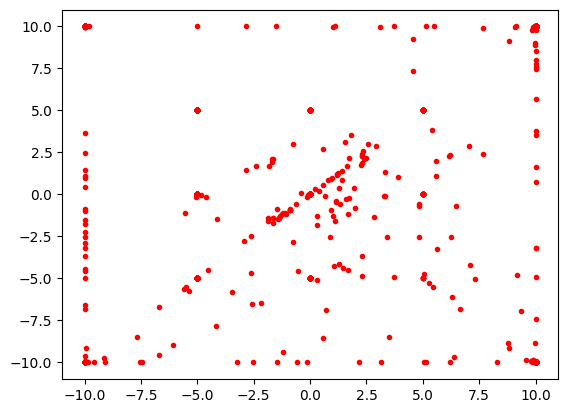

In [14]:
plt.figure()
plt.plot(RF_ss5_fFit[:, :, :, 5].flatten(), RF_ss5_fFit[:, :, :, 6].flatten(), 'r.')
plt.show()

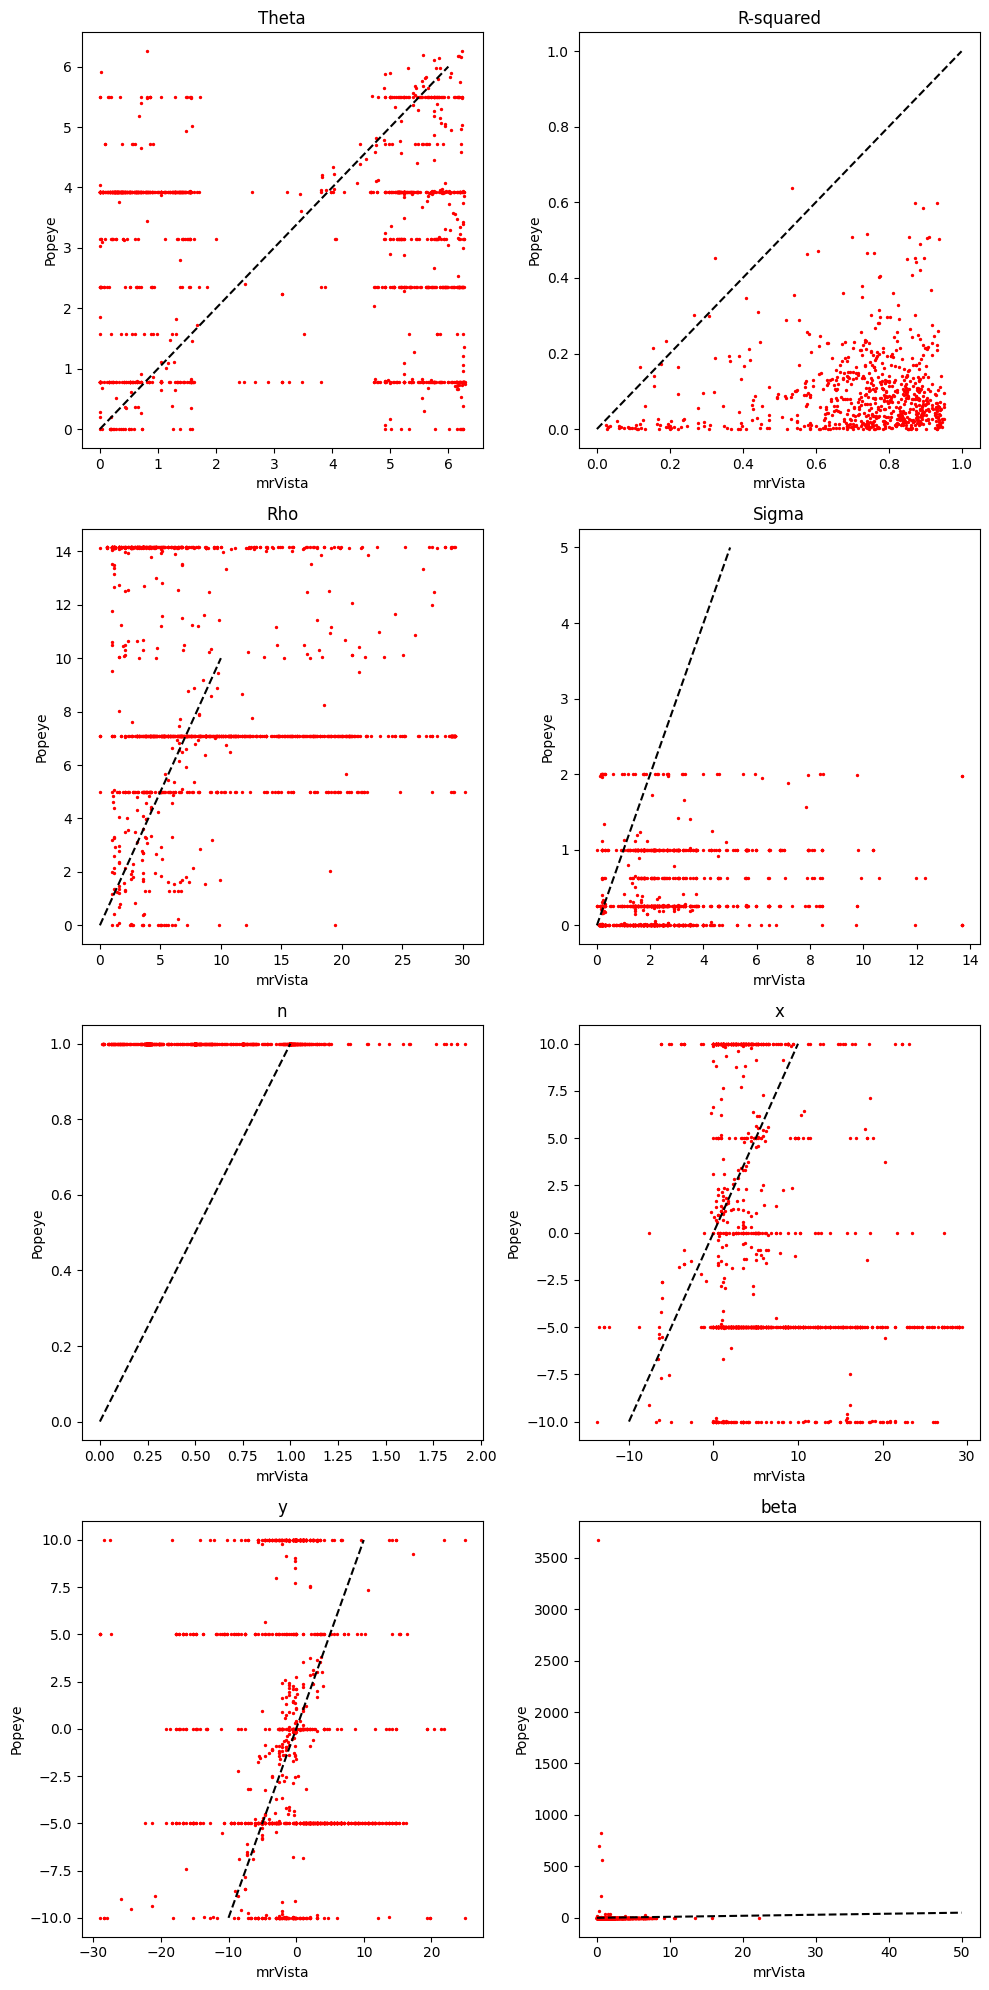

In [15]:
# Assume visual_rois, mrVista_fit, and RF_ss5_fFit are already defined
nrows = 4
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 20))

titles = ['Theta', 'R-squared', 'Rho', 'Sigma', 'n', 'x', 'y', 'beta']
limits = [
    (0, 6),  # Theta
    (0, 1),  # R-squared
    (0, 10), # Rho
    (0, 5),  # Sigma
    (0, 1),  # n
    (-10, 10), # x
    (-10, 10), # y
    (0, 50)   # beta
]

# Setting up the axes
for i, ax in enumerate(axs.flat):
    ax.set_title(titles[i])
    ax.set_xlabel('mrVista')
    ax.set_ylabel('Popeye')
    ax.plot(limits[i], limits[i], 'k--')

# Populating the scatter plots
for ix in range(visual_rois.shape[0]):
    for iy in range(visual_rois.shape[1]):
        for iz in range(visual_rois.shape[2]):
            if visual_rois[ix, iy, iz] == 1:
                for i, ax in enumerate(axs.flat):
                    ax.scatter(mrVista_fit[ix, iy, iz, i], RF_ss5_fFit[ix, iy, iz, i], c='r', s=2)

plt.tight_layout()
plt.show()

In [ ]:
gaussian_model = og.GaussianModel(stimulus, utils.double_gamma_hrf, normalizer=utils.percent_change)
gaussian_model.hrf_delay = 0
gaussian_model.mask_size = 5 # standard deviations of the gaussian

# Create scan data just for visual ROIs
scan_data_visual = scan_data.copy()
scan_data_visual[~visual_rois] = 0

[xi, yi, zi] = np.nonzero(visual_rois)
indices = [(xi[i], yi[i], zi[i]) for i in range(len(xi))]
num_voxels = len(indices)
timeseries_data = scan_data_visual[xi, yi, zi, :]

# set search grids
x_grid = utils.grid_slice(-12.0, 12.0, 3)
y_grid = utils.grid_slice(-12.0, 12.0, 3)
s_grid = utils.grid_slice(1/gaussian_model.stimulus.ppd0, 5.0, 3)
# h_grid = utils.grid_slice(-1.0, 1.0, 3)
grids = (x_grid, y_grid, s_grid,)

# Set search bounds
x_bounds = (-10.0, 10.0)
y_bounds = (-10.0, 10.0)
s_bounds = (1/gaussian_model.stimulus.ppd0, 2.0)
# h_bounds = (0.001, 12.0)
b_bounds = (1e-8, None)
m_bounds = (None, None)
bounds = (x_bounds, y_bounds, s_bounds, b_bounds, m_bounds)

verbose = 0
auto_fit = 1
# bundle = utils.multiprocess_bundle(og.GaussianFit, gaussian_model, timeseries_data, grids, bounds, indices, auto_fit=autofit, verbose=verbose)